# Simple Examples of Solving PDEs with DL

In [7]:
from torch import optim

%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D

from nets import *
from pdes import *
from utils import *
from graphics import *
from solutions import *

## Advection Equation

In this section, we consider the 1st order non-stationary pde for different right-hand sides $f$.
These are:  
* cell A  $\quad f = 0$  
* cell B  $\quad f = x$  
* cell C  $\quad f = \theta(x-s) \quad$ (where $\theta$ is the Heaviside step function, $s$ - shift)
* cell D  $\quad f = u(1-u)$

### Numerical Solution
explicit finite-difference scheme

$$\left\{\begin{aligned}
    &u_i^{n+1} = u_i^n - \frac{a\Delta t}{\Delta x} (u_i^n- u_{i-1}^n)\\
    &u_i^0 = \exp(-\alpha(i\Delta h - s)^2)\\
    &u_0^n = 0
\end{aligned}\right.$$

### Analytical Solution
Presented only for r.h.s. $u(1-u)$

$$\left\{\begin{aligned}
    &u_t + au_x = ru(1-u), \quad &&(t, x) \in (0, T]\times(0, l]\\
    &u\;\big|_{\,t=0} = e^{-\alpha(x - s)^2}, \quad && x\in[0, l]\\
    &u\;\big|_{\,x=0} = e^{-\alpha s^2}, \quad && t \in [0, T]
\end{aligned}\right.$$

**Method of Characteristics:**

$\xi = x - at, \quad\eta = t$  
$u = u(\xi(t, x), \eta(t, x))$  

$u_t = u_\xi \xi_t + u_\eta \eta_t = -au_\xi + u_\eta$  
$u_x = u_\xi \xi_x + u_\eta \eta_x = u_\xi$

$u_t + au_x = u_\eta$

When $\eta = 0$, $\xi = x \ge 0$  
When $x = 0$, $\xi = -at = -a\eta \le 0$

$$\left\{\begin{aligned}
    &u_\eta = ru(1-u)\\
    &u\;\big|_{\,\eta=0} = e^{-\alpha(\xi - s)^2} \triangleq g(\xi), \quad &&\xi \ge 0\\
    &u\;\big|_{\,\eta=-\frac{\xi}{a}} = e^{-\alpha s^2} \triangleq g(0), \quad &&\xi < 0
\end{aligned}\right.$$

**Solving ODE:**

$$\begin{gather*}
    \frac{du}{u} + \frac{du}{1-u} = \frac{du}{u(1-u)} = rd\eta\\
    \ln u - \ln(1-u) = r\eta + \tilde f(\xi)\\
    \frac{u}{1-u} = f(\xi)\,e^{r\eta}\\
    u = \frac{f(\xi)}{f(\xi) + e^{-r\eta}}
\end{gather*}$$

$f(\xi)$ is unknown

**Applying BC:**

$$\begin{gather*}
    u\;\big|_{\,\eta=0} = \frac{f(\xi)}{f(\xi) + 1} = g(\xi)\\
    f(\xi) = \frac{g(\xi)}{1-g(\xi)}, \quad \xi \ge 0
\end{gather*}$$

&nbsp;&nbsp;

$$\begin{gather*}
    u\;\big|_{\,\eta=-\frac{\xi}{a}} = \frac{f(\xi)}{f(\xi) + e^{r\frac{\xi}{a}}} = g(0)\\
    f(\xi) = \frac{g(0)}{1-g(0)}e^{r\frac{\xi}{a}}, \quad \xi < 0
\end{gather*}$$

### Solving with DL

Let $f$ be a function modeled by a neural network and an approximation to the solution of a PDE, $u$.
We want $f$ to satisfy differential operator $\mathcal L$, boundary and initial conditions
($\mathcal B$ and $\mathcal C$, respectively).
Applying operators ($\mathcal L, \mathcal B$ or $\mathcal C$) to the true solution
(which is unique in the cases considered in the current work) gives zero.
Thus, substituting any other function $f$ different from $u$ will produce residuals:
$r_1 = \mathcal Lf,\; r_2 = \mathcal Bf,\; r_3 = \mathcal Cf$.
This can be used for the loss construction: $L = w_1 r_1 + w_2 r_2 + w_3 r_3$. The next steps are known. We train a network by computing the loss and backpropogating through it.

---
### Experiments
Parameters' setting

In [8]:
l = 1.
T = 1.
dx = 1e-3
a = .5

# case-specific parameters
r = 10.
s = .25
alpha = 200.
width = .1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Numerical part

Cell **A**

In [96]:
initial = lambda x: dome(x, a=a, alpha=alpha, shift=s)
initial = partial(dome, a=a, alpha=alpha, shift=s)
solver = AdvectionSolver(initial, a, l, T, dx, device)
x = solver.x
solver.buildRHS(0.)

u_approx = solver.solve(True)
u_exact = dome(x, t=T, a=a, shift=s)

Cell **B**

In [3]:
initial = lambda x: xpdome(x, a=a, alpha=alpha, shift=s)
solver = AdvectionSolver(initial, a, l, T, dx, device)
x = solver.x
solver.buildRHS(x[1:])

u_approx = solver.solve(True)
u_exact = xpdome(x, t=T, a=a, shift=s)

Cell **C**

In [11]:
initial = lambda x: step_function(x, a=a, width=width, shift=s)
solver = AdvectionSolver(initial, a, l, T, dx, device)
x = solver.x
solver.buildRHS(0)

u_approx = solver.solve(True)
u_exact = step_function(x, t=T, a=a, width=width, shift=s)

Cell **D**

In [9]:
initial = lambda x: dome(x, shift=s)
solver = AdvectionSolver(initial, a, l, T, dx, device)
x = solver.x

old_1tstep = solver._oneTimeStep

def new_1tstep(u):
    solver.buildRHS(r*u[1:]*(1-u[1:]))
    u = old_1tstep(u)
    return u

solver._oneTimeStep = new_1tstep

u_approx = solver.solve(True)
u_exact = fkdome(x, T, a, r, shift=s)

*Plot the results of numerical approximation for the chosen cell*

max error 0.19751760363578796
avg error 0.042918652296066284


<IPython.core.display.Javascript object>


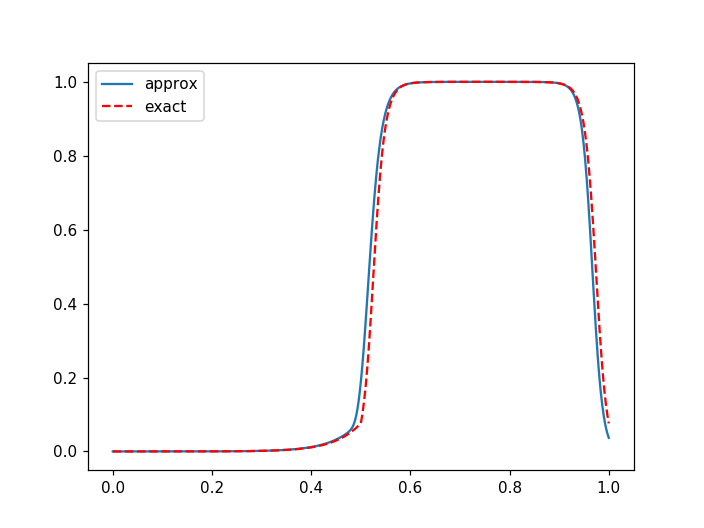

In [5]:
print('max error', max_error(u_exact, u_approx).item())
print('avg error', avg_error(u_exact, u_approx).item())
plt.figure()
plt.plot(x.cpu(), u_approx.cpu(), label='approx')
plt.plot(x.cpu(), u_exact.cpu(), '--r', label='exact')
plt.legend();

#### Solution obtained with DL

Cell **A**

In [102]:
t_seg = (0., 1.)
rhs = lambda t,x,u: 0
initial = partial(dome, t=t_seg[0], a=a, alpha=alpha, shift=s)
net = DumbLinear('3l', base_width=128).to(device)
get_true = partial(dome, a=a, alpha=alpha, shift=s)

Cell **B**

In [16]:
t_seg = (0., 1.)
rhs = lambda t,x,u: x
initial = partial(xpdome, t=t_seg[0], a=a, alpha=alpha, shift=s)
net = RNNLikeDGM(
    d_in=2, d_out=1, M=50, L=3,
    growing=True, as_array=False).to(device)
get_true = partial(xpdome, a=a, alpha=alpha, shift=s)

file_to_load = '../weights/advection-xpdome.tar'

Cell **C**

In [ ]:
t_seg = (0., 1.)
rhs = lambda t,x,u: 0
initial = partial(step_function, t=t_seg[0], a=a, width=width, shift=s)
net = DumbLinear('3l', base_width=128).to(device)
get_true = partial(step_function, a=a, width=width, shift=s)

#file_to_load = '../weights/advection-heaviside.tar'

Cell **D**

In [10]:
t_seg = (0., 1.)
rhs = lambda t,x,u: r*u*(1-u)
initial = partial(xpdome, t=t_seg[0], a=a, alpha=alpha, shift=s)
net = RNNLikeDGM(
    d_in=2, d_out=1, M=50, L=3,
    growing=False, as_array=False).to(device)
get_true = partial(fkdome, a=a, r=r, alpha=alpha, shift=s)

---

**Network training procedure + validation**

In [11]:
pde = UpdatedAdvectionPDE(
    initial, a=a, l=l, T=t_seg,
    rhs=rhs, device=device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(net, np.arange(n_devices))

w = torch.ones(3).to(device)
w[0] *= 1./r
param_list = list(net.parameters())
if w.requires_grad:
    param_list += [w]
optimizer = optim.Adam(param_list, lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=.9)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 200, eta_min=1e-7)

You have 0 gpus


In [20]:
#trainer = SepLossTrainer(w, net, pde, optimizer, scheduler)
trainer = SepLossTrainer(net, pde, optimizer, scheduler, k=2, refinement='GAR')
x = torch.linspace(0, l, int(l/dx)+1, device=device)
t = torch.linspace(*t_seg, 100, device=device)
X = torch.meshgrid(t, x)
Y = get_true(x, t)

Early stop due to the loss explosion


<IPython.core.display.Javascript object>


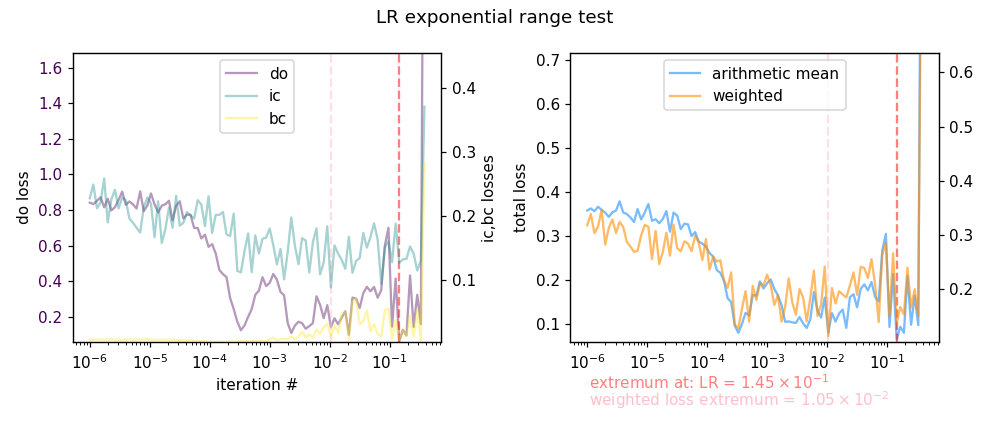


Minimum loss value (mean): 0.23290569


In [13]:
trainer.exponentialWarmUp(w, 128, 100, lr_lims=(1e-6, 1.), range_test=True, explosion_ratio=2)

In [15]:
for _ in trange(100):
    trainer.trainOneEpoch(w)
    trainer.validate(X, Y)

100%|██████████| 10/10 [01:00<00:00,  6.05s/it]


In [8]:
trainer.terminate()

Best validation score is 0.26817741990089417
Achived at epoch #2


<IPython.core.display.Javascript object>


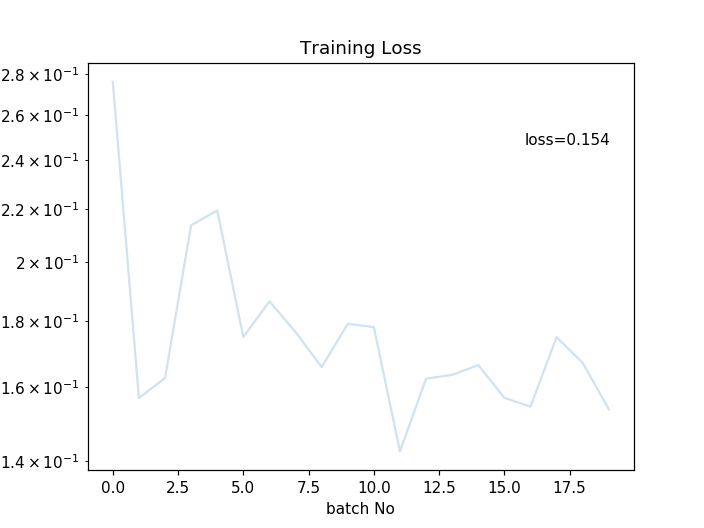

In [19]:
fig, ax = plt.subplots()
ax.plot(trainer.history, alpha=.2)
ax.text(
    .8, .8, 'loss={:.3f}'.format(trainer.history[-1]), 
    transform = ax.transAxes)
ax.set_yscale('log')
ax.set_ylabel('Error')
ax.set_xlabel('batch No')
plt.title('Training Loss');

**Load weights of a trained network (gpu models for inference on cpu)**

*At the time, not all pretrained models are added*

In [17]:
checkpoint = torch.load(file_to_load, map_location=device)
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

**Initial condition approximation**

max error 0.0010386258363723755
avg error 0.00042037322418764234


<IPython.core.display.Javascript object>


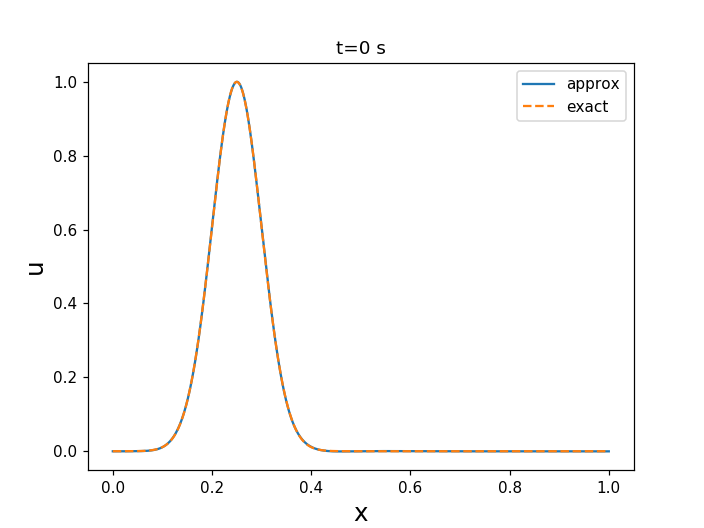

In [18]:
o = torch.empty_like(x).fill_(t_seg[0])
y_true = initial(x)
y = net(o, x).detach()

print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu()
y = y.cpu()
y_true = y_true.cpu()

plt.figure()
plt.plot(x, y, label='approx')
plt.plot(x, y_true, '--', label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('t=0 s')
plt.legend();

**Approximation at time `t`**

max error 0.001833200454711914
avg error 0.0007505501853302121


<IPython.core.display.Javascript object>


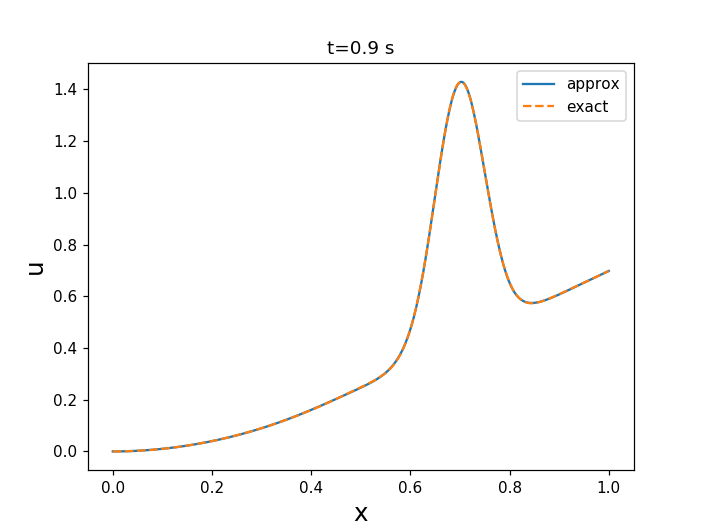

In [19]:
t_val = .9
t = torch.empty_like(x).fill_(t_val)

y_true = get_true(x, t_val)
y = net(t, x).detach()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu()
y = y.cpu()
y_true = y_true.cpu()

plt.figure()
plt.plot(x, y, label='approx')
plt.plot(x, y_true, '--', label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();

**Run cell to start animating**  
if there is only one graph, re-run the cell

---
As expected, the approximation is fairly good on the training data, and when the model encounters test data the solutions begin to diverge

<IPython.core.display.Javascript object>


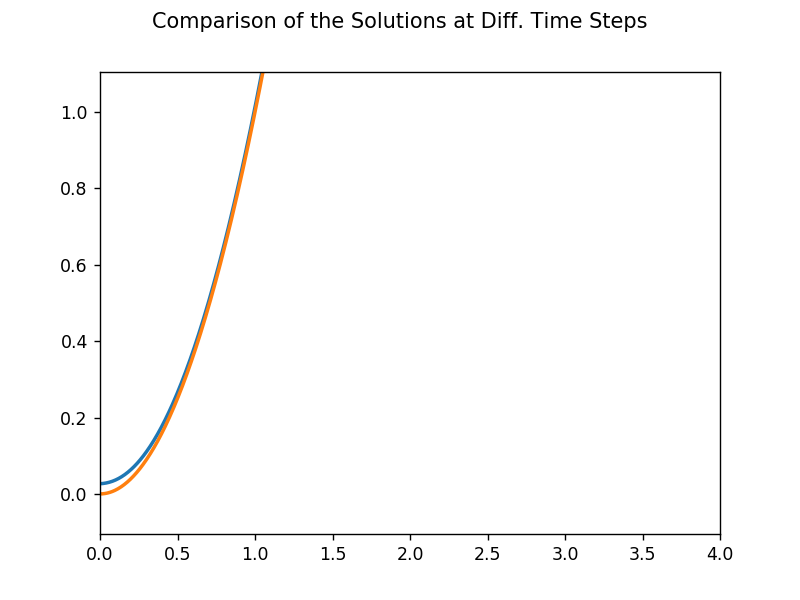

In [14]:
z = torch.linspace(0, 4*l, 1000)
t = torch.linspace(0, 4*T)
y = get_true(z, t)
true_data = (z, y)

_t, _x = torch.meshgrid(t, z)
y = net(_t.to(device), _x.to(device)).detach().cpu()
appr_data = (z, y)

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

### Notes

Training of the network in the case of great parameter values of nonlinear right-hand side requires the balance between differential operator and initial condition loss parts. Moreover, one must adjust the learning rate to be large enough in the begining and schedule of changes

For unbounded solutions -- I tested $f=ru$, i.e. `rhs=lambda t,x,u: r*u` or just `u` and loss stabilization, and $f=x$ (the former is not presented in the report, the latter does) - you need to set `growing=True` in the net's constructor

---
## Fisher-Kolmogorov Equation
### Numerical Solution
finite-difference (explicit and implicit schemes) and nonstandard finite-difference methods

---
* **Case described in [the paper](https://core.ac.uk/download/pdf/82343686.pdf)**
$$
\left\{\begin{aligned}
    &u_t - u\,u_{xx} = u(1-u), &&\quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = 0, &&\quad x \in (0,l]\\
    &u(t, 0) = 1, &&\quad t \in [0,T]\\
    &u(t, l) = 0, &&\quad t \in [0,T]\\
    &0 \le u(t, x) \le 1\\
\end{aligned}\right.
$$

**Nonstandard Finite Difference Method (NSFDM)** for the problem above

$$
    \frac{u^{n+1}_m - u^n_m}{\phi(\Delta t)}
    = u^{n+1}_m \left[\frac{u^n_{m+1} - 2u^n_m + u^n_{m-1}}{\psi(\Delta x)}\right]
    + 2\bar u^n_m - u^{n+1}_m - u^{n+1}_m \bar u^n_m
$$

$$
    \bar u^n_m \equiv \frac{u^n_{m+1} + u^n_{m-1}}{2}
$$

One can check that this scheme is stable (considering that initial values of $0 < u < 1$)
if $\frac{\phi(\Delta t)}{\psi(\Delta x)} \lt \frac{1}{2}$ (without any spectral analysis).
The stability condition might be or might be not weakened, if analyzed more thoroughly

Here, the 'denominator function' (calling such both $\psi$ and $\phi$ in general) satisfies:

$$
    \varphi(h, \lambda) = h + O(h^2)
$$

$\lambda$ is some hyperparameter that might appear in PDEs (as an example of $\varphi$ you can consider $\exp(\bullet) - 1$)  
For the sake of simplicity, we can take $\quad\phi(\Delta t) = \Delta t, \qquad \psi(\Delta x) = (\Delta x)^2$  
What else is worth mentioning here is that terms $u$ and $u^2$ are discretized non-locally
($u \to 2\bar u^n_m - u^{n+1}_m$ instead of just $u^n_m$, and likewise, $u^2 \to u^{n+1}_m\bar u^n_m$)  
Local discretization in turn prevents the propagation of diffusion process (see in [the paper](https://core.ac.uk/download/pdf/82343686.pdf) how)

This scheme is explicit, so we can write
$$
    u^{n+1}_m = \frac{u^n_m + 2\phi\bar u^n_m}{1+ \phi + \frac{2\phi}{\psi}(u^n_m - \bar u^n_m)+\phi\bar u^n_m}
$$

* **Explicit scheme for FK equation**

Also, we can consider similar problem:

$$
\left\{\begin{aligned}
    &u_t - a\,u_{xx} = ru(1-u), &&\quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = g(x), &&\quad x \in [0,l]\\
    &u(t, 0) = g(0), &&\quad t \in [0,T]\\
    &u(t, l) = g(l), &&\quad t \in [0,T]\\
    &0 \le u(t, x) \le 1\\
\end{aligned}\right.
$$

For this problem formulation, we can write the following explicit scheme
($u \to \bar u^n_m,\; u^2 \to u^{n+1}_m \bar u^n_m)$:

$$
    u^{n+1}_m = \frac{(1 - \frac{2a\phi}{\psi})u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m}
    {1 + r\phi\bar u^n_m}
$$

With simple stability analysis, we have $\frac{2a\phi(\Delta t)}{\psi(\Delta x)} \lt 1$:  

$$
    u^{n+1}_m \ge 0 \quad\longrightarrow\quad \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m \ge 0, \quad\forall u^n_m, \bar u^n_m \in [0, 1]\\
    \Longrightarrow 1 - \frac{2a\phi}{\psi} \ge 0
$$

$$
    u^{n+1}_m \le 1 \quad\longrightarrow\quad \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m \;\le\; 1 + r\phi\bar u^n_m\\
    \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m \;\le\; 1, \quad\forall u^n_m, \bar u^n_m \in [0, 1]\\
$$

Considering all possible $u^n_m, \bar u^n_m \in [0, 1]$, we come to the condition above

* **Implicit scheme**

$$
    \frac{u^n_m - u^{n-1}_m}{\phi(\Delta t)}
    = a\frac{u^n_{m+1} - 2u^n_m + u^n_{m-1}}{\psi(\Delta x)}
    + ru(1-u)
$$

$$
    -\mu u^n_{m-1} + (1+2\mu)u^n_m - \mu u^n_{m+1}
    = u^{n-1}_m + r\phi u^{n-1}_m(1-\bar u^{n-1}_m)
$$

Where $\mu = \frac{a\phi}{\psi}$  
Rewrite it as the system

$$\begin{pmatrix}
1+2\mu& -\mu \\
-\mu& 1+2\mu& -\mu\\
& \ddots & \ddots & \ddots\\
& &  -\mu& 1+2\mu& -\mu\\
& & & -\mu& 1+2\mu
\end{pmatrix}
\begin{pmatrix}
U^n_1 \\
U^n_2 \\
\vdots \\
U^n_{M-3}\\
U^n_{M-2}
\end{pmatrix}
= \begin{pmatrix}
U^{n-1}_1(1 - r\phi\bar U^{n-1}_1) + \mu g_0\\
U^{n-1}_2(1 - r\phi\bar U^{n-1}_2)\\
\vdots\\
U^{n-1}_{M-3}(1 - r\phi\bar U^{n-1}_{M-3})\\ 
U^{n-1}_{M-2}(1 - r\phi\bar U^{n-1}_{M-2}) + \mu g_M\\
\end{pmatrix}
$$

**Stability analysis**

The matrix is p.d. $\rightarrow$ the scheme is unconditionally stable (\*almost)

**Cholesky decomposition of a 3-diagonal symmetric matrix**

$$
\begin{pmatrix}
    a& b \\
    b& a& b\\
    & \ddots & \ddots & \ddots\\
    & &  b& a& b\\
    & & & b& a
\end{pmatrix}
=
\begin{pmatrix}
    l_0\\
    m_0& l_1\\
    & \ddots & \ddots\\
    & & m_{n-3}& l_{n-2}\\
    & & & m_{n-2}& l_{n-1}\\
\end{pmatrix}
\begin{pmatrix}
    l_0& m_0\\
    & l_1 & m_1\\
    & & \ddots & \ddots\\
    & & & l_{n-2}& m_{n-2}\\
    & & & & l_{n-1}\\
\end{pmatrix}
$$

To determine $L$
$$
    a = A_{00} = l_0^2\\
    a = A_{ii} = m_{i-1}^2 + l_i^2, \quad i > 0\\
    b = A_{i-1, i} = A_{i,i-1} = m_{i-1}l_{i-1}, \quad i > 0
$$

$$
\begin{pmatrix}
    l_0\\
    m_0& l_1\\
    & \ddots & \ddots\\
    & & m_{n-3}& l_{n-2}\\
    & & & m_{n-2}& l_{n-1}\\
\end{pmatrix}
\begin{pmatrix}
    y_0\\
    y_1\\
    \vdots\\
    y_{n-2}\\
    y_{n-1}
\end{pmatrix}
=
\begin{pmatrix}
    f_0\\
    f_1\\
    \vdots\\
    f_{n-2}\\
    f_{n-1}
\end{pmatrix}
$$

To solve $Ly = f$:
$$
    l_0y_0 = f_0\\
    m_{i-1}y_{i-1} + l_iy_i = f_i, \quad i > 0
$$

$$
\begin{pmatrix}
    l_0& m_0\\
    & l_1 & m_1\\
    & & \ddots & \ddots\\
    & & & l_{n-2}& m_{n-2}\\
    & & & & l_{n-1}\\
\end{pmatrix}
\begin{pmatrix}
    x_0\\
    x_1\\
    \vdots\\
    x_{n-2}\\
    x_{n-1}
\end{pmatrix}
=
\begin{pmatrix}
    y_0\\
    y_1\\
    \vdots\\
    y_{n-2}\\
    y_{n-1}
\end{pmatrix}
$$

To solve $L^\top x = y$:
$$
    l_ix_i + m_ix_{i+1} = y_i, \quad i < N-1\\
    l_{n-1}x_{n-1} = y_{n-1}
$$

### Analytical solution for $r=0$
$$\left\{\begin{aligned}
    &u_t - a\,u_{xx} = 0, &&\quad (t,x) \in [0,T]\times[0, l],\; a > 0\\
    &u(0, x) = e^{-\alpha |x-\frac{l}{2}|}, &&\quad x \in [0,l]\\
    &u(t, 0) = e^{-\alpha \frac{l}{2}}, &&\quad t \in [0,T]\\
    &u(t, l) = e^{-\alpha \frac{l}{2}}, &&\quad t \in [0,T]\\
\end{aligned}\right.$$

---
Zero the boundary conditions by:
    $$u = v + e^{-\alpha\frac{l}{2}}$$
    
Which gives:
$$\left\{\begin{aligned}
    &v_t - a\,v_{xx} = 0, &&\quad (t,x) \in [0,T]\times[0, l]\\
    &v(0, x) = e^{-\alpha |x-\frac{l}{2}|} - e^{-\alpha\frac{l}{2}}, &&\quad x \in [0,l]\\
    &v(t, 0) = 0, &&\quad t \in [0,T]\\
    &v(t, l) = 0, &&\quad t \in [0,T]\\
\end{aligned}\right.$$

---
Seeking the solution in the form $v \sim \sum_k \Theta_k(t)X_k(x)$.  
$\left(\Theta' X = a\Theta X'' \rightarrow \frac{\Theta'}{a\Theta} = \frac{X''}{X} = -\lambda\right)$  
The spatial basis' functions are eigenfunctions of the operator $-\frac{d^2}{dx^2}$:

$$
    X_k(x) = \sin\frac{\pi k}{l} x, \quad k = \overline{1, \infty}
$$

Expand $v(0, x)$ in the basis of $X_k$:

$$\begin{gather*}
    -\frac{2}{l}e^{-\alpha\frac{l}{2}}\int_0^l \sin\frac{\pi k}{l}x\;dx
    =\color{red}{\frac{2}{\pi k}e^{-\alpha\frac{l}{2}}\big(\cos\pi k - 1\big)}\\
    \frac{2}{l}\int_0^l e^{-\alpha |x-\frac{l}{2}|}\sin\frac{\pi k}{l}x\;dx
    = \frac{2}{l}\int_0^\frac{l}{2} e^{\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
    + \frac{2}{l}\int_\frac{l}{2}^l e^{-\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
\end{gather*}$$

&nbsp;&nbsp;

$$\begin{gather*}
    J_1 = \frac{2}{l}\int_0^\frac{l}{2} e^{\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx = 
    \frac{2}{\pi k}\int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;\bigg|_0^\frac{\pi k}{2}
    -\frac{2}{\alpha l}\int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2 \pi k}{(\alpha l)^2}e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;\bigg|_0^\frac{\pi k}{2}
    -\left(\frac{\pi k}{\alpha l}\right)^2\frac{2}{\pi k}
    \int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}-\frac{2 \pi k}{(\alpha l)^2}\cos\frac{\pi k}{2}
    +\frac{2 \pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}
    -\left(\frac{\pi k}{\alpha l}\right)^2 J_1
\end{gather*}$$

&nbsp;&nbsp;

$$\begin{gather*}
    J_2 = \frac{2}{l}\int_\frac{l}{2}^l e^{-\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
    = \frac{2}{\pi k}\int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k}(y-\frac{\pi k}{2})}\sin y\;dy\\
    =-\frac{2}{\alpha l}e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;\bigg|_\frac{\pi k}{2}^{\pi k}
    +\frac{2}{\alpha l}\int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2\pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{\pi k}
    (y-\frac{\pi k}{2})}\cos y\;\bigg|_\frac{\pi k}{2}^{\pi k}
    -\left(\frac{\pi k}{\alpha l}\right)^2\frac{2}{\pi k}
    \int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2\pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}\cos\pi k
    +\frac{2\pi k}{(\alpha l)^2}\cos \frac{\pi k}{2}
    -\left(\frac{\pi k}{\alpha l}\right)^2 J_2
\end{gather*}$$

&nbsp;&nbsp;

$$\begin{gather*}
    J = J_1 + J_2 =  \frac{4}{\alpha l}\sin\frac{\pi k}{2}
    +\frac{2 \pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}(1 -\cos\pi k)
    -\left(\frac{\pi k}{\alpha l}\right)^2 (J_1 + J_2)\\
    J = \color{red}{\frac{4\alpha l\sin\frac{\pi k}{2}
    + 2\pi k e^{-\frac{\alpha l}{2}}(1 -\cos\pi k)}{\alpha^2l^2 + \pi^2k^2}}
\end{gather*}$$

---
Frame the problem for the temporal part:

$$\left\{\begin{aligned}
    &\theta_k\,'(t) + \lambda_k a\;\theta_k(t) = 0, \quad t \in [0,T]\\
    &\theta_k(0) = A_k \\
\end{aligned}\right.$$

$$\theta_k(t) = A_ke^{-\lambda_k at}$$
Here $A_k$ is the sum of red expressions calculated above, and $\lambda_k = \left(\frac{\pi k}{l}\right)^2$  
Ultimately, we have for $v$:
$$u(t, x) = \sum_{k=1}^\infty A_ke^{-\lambda_k at} \sin\sqrt{\lambda_k} x$$

$$
    A_{2m} = 0\\
    A_{2m+1} = 4\frac{(-1)^m\alpha l + \pi(2m+1) e^{-\frac{\alpha l}{2}}}{\alpha^2l^2 + \pi^2(2m+1)^2}
    - \frac{4}{\pi (2m+1)}e^{-\frac{\alpha l}{2}}
$$

And for $u$:
$$u(t, x) = e^{-\alpha\frac{l}{2}} + \sum_{m=0}^\infty A_{2m+1}e^{-\lambda_{2m+1}at} \sin\sqrt{\lambda_{2m+1}} x$$

In [4]:
# parameters' setting
l = 1.
T = .1
r = 0.
dx = 1e-3
dt = 1e-3
a = .1

initial = lambda x: spike(x, alpha=10., shift=.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
solver1 = ExplicitFisherSolver(initial, a, r, l, T, dx, device)

x = solver1.x
u0 = solver1.u0
solver2 = ImplicitFisherSolver(u0.cpu().numpy(), a, r, l, T, dx, dt)

u_ex = solver1.solve(True)
u_im = solver2.solve(True)

solver = PartialSolver(a, alpha, l)
u_exact = solver.solve(T, x, 1e-4)[0]

<IPython.core.display.Javascript object>


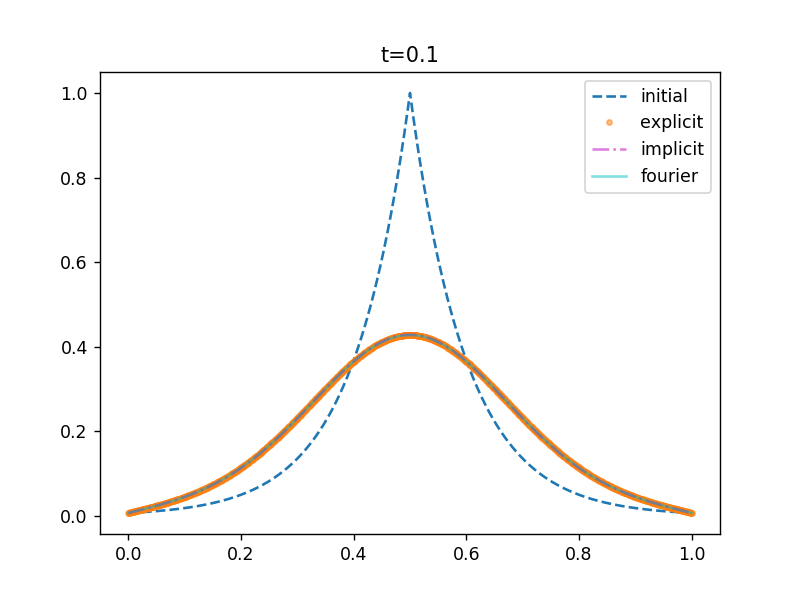

In [16]:
plt.figure()
plt.plot(x.cpu(), u0.cpu(), '--', label='initial')
plt.plot(x.cpu(), u_ex.cpu(), '.', label='explicit', alpha=.5)
plt.plot(x.cpu(), u_im, 'm-.', label='implicit', alpha=.5)
plt.plot(x.cpu(), u_exact.cpu(), 'c', label='fourier', alpha=.5)
plt.title(f't={T}')
plt.legend();

### Solution obtained with DL 

Taking the hessian of a network is a computationally expensive operation in case of high dimensional problems (<span style='color:blue'>**not considered here, in this work**</span>), since backpropagation through the upper triangle of hessian (including the diagonal) will cost $O(d^3\times N)$ in number of operations. So, not a bad resolution here is to use linear approximation to calculate the hessian matrix  

As an approximation to the second derivative ($Lf \triangleq\partial_{xx} f, \; f$ is a function of $(t, x)$)
we can take the following expression:

$$
    \hat Lf = \frac{\partial_x f(t,x+r\delta) - \partial_x f(t,x)}{\delta^2}r\delta \quad (*)
$$

Where $r \sim \mathcal N(0, 1)$

Taylor expansion of $\partial_x f$ at the point $(t,x) is$:  

$$
    \partial_x f(t, x+r\delta) = \partial_x f(t, x) + r\delta\cdot\partial_{xx} f(t, x) + O(\delta^2)
$$

Substitute into $(*)$ and take the expectation

$$\begin{gather*}
\hat Lf = \partial_{xx}f(t,x)r^2 + O(\delta)\\
\mathbb E_{r\sim\mathcal N(0,1)}[\hat Lf] = \partial_{xx}f(t,x) + O(\delta)
\end{gather*}$$

The bias $O(\delta)$ can be improved to $O(\delta^2)$ using "antithetic variates" method.
How it looks in application to the general case is described in [the article](https://arxiv.org/pdf/1708.07469.pdf)  
Here I consider 1D case

$$\begin{gather*}
    G_a = \left(\partial f(t,x) - a\frac{\partial_x f(t,x+r\delta)
    - \partial_x f(t,x)}{\delta^2}r\delta\right)
    \left(\partial f(t,x) - a\frac{\partial_x f(t,x+\tilde r\delta)
    - \partial_x f(t,x)}{\delta^2}\tilde r\delta\right)\\
    G_b = \left(\partial f(t,x) + a\frac{\partial_x f(t,x-r\delta)
    - \partial_x f(t,x)}{\delta^2}r\delta\right)
    \left(\partial f(t,x) + a\frac{\partial_x f(t,x-\tilde r\delta)
    - \partial_x f(t,x)}{\delta^2}\tilde r\delta\right)
\end{gather*}$$

$$
    G = G_a + G_b
$$

$G$ is an approximation to the gradient of differential operator loss.
$G_a$ and $G_b$ are negatively correlated. $r$ and $\tilde r$ are independent random variables sampled from standard normal distribution $\mathcal N(0, 1)$

In [10]:
# Execute the cell above first (the one with parameters' setting)
pde = FisherPDE(initial, device=device, useAV=True)
net = RNNLikeDGM(d_in=2, d_out=1, M=50, L=3, as_array=False).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(net,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1e5, 1.4e5], .4)

You have 0 gpus


In [4]:
trainer = Trainer(net, pde, optimizer, scheduler)
for _ in trange(100):
    trainer.trainOneEpoch()

100%|██████████| 100/100 [17:40<00:00, 10.60s/it]


<IPython.core.display.Javascript object>


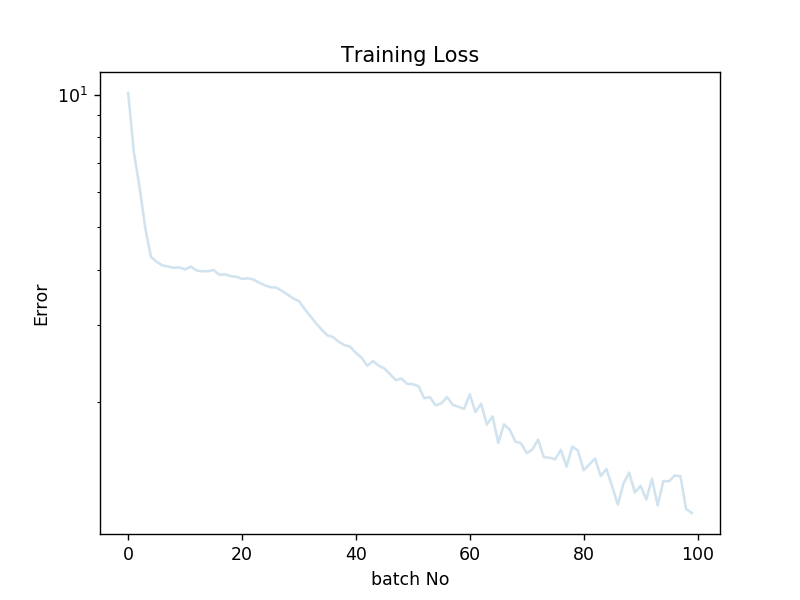

In [5]:
plt.figure()
plt.plot(trainer.history, alpha=.2)
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');

**Load the pretrained model to solve FK pde**
* r = 0

In [6]:
checkpoint = torch.load('../weights/fisher-r=0.tar', map_location=device)
initial = lambda x: spike(x, alpha=10., shift=.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = RNNLikeDGM(d_in=2, d_out=1, M=50, L=3, as_array=False).to(device)
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

max error 0.012395702302455902
avg error 0.0064646219834685326


<IPython.core.display.Javascript object>


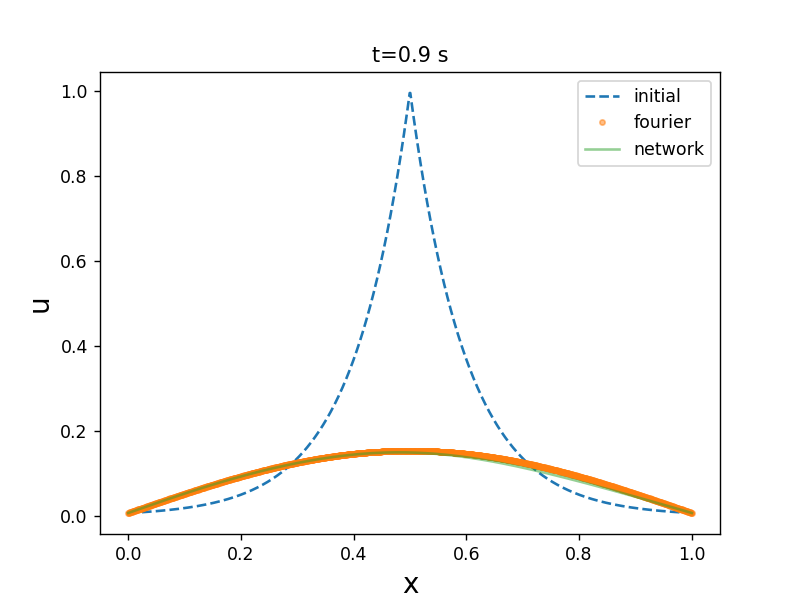

In [7]:
r = 10.
alpha = 10.

solver = PartialSolver(a, alpha, l)

t_val = .9
x = torch.linspace(0, 1, 1000, device=device)
y_initial = spike(x, shift=.5)

t = torch.empty_like(x).fill_(t_val)
y = net(t, x).detach()

y_true = solver.solve(t_val, x, 1e-4)[0]
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu()

plt.figure() 
plt.plot(x, y_initial.cpu(), '--', label='initial')
plt.plot(x, y_true.cpu(), '.', label='fourier', alpha=.5)
plt.plot(x, y.cpu(), label='network', alpha=.5)
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();

* r = 10

In [8]:
checkpoint = torch.load('../weights/fisher-r=10.tar', map_location=device)
initial = lambda x: dome(x, alpha=200., shift=.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = RNNLikeDGM(d_in=2, d_out=1, M=50, L=3, as_array=False).to(device)
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

max difference 0.00022399425506591797
avg difference 9.276624768972397e-05


<IPython.core.display.Javascript object>


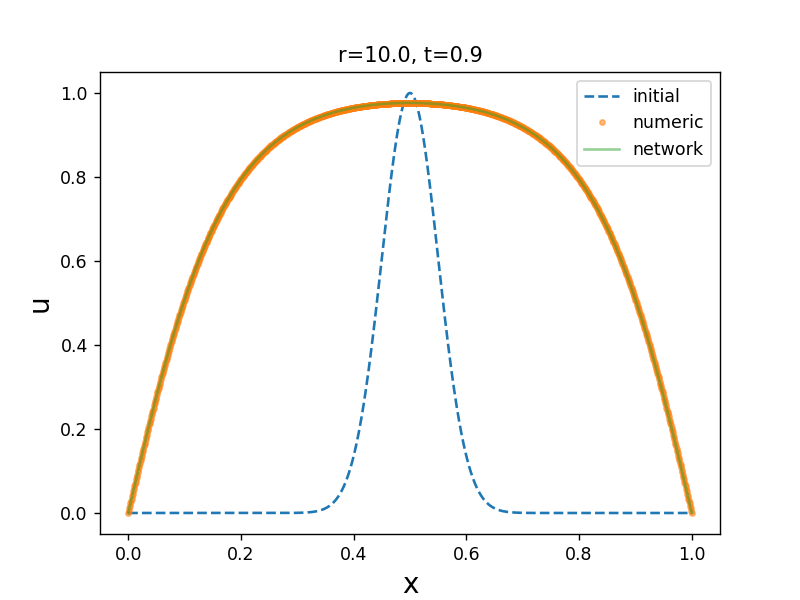

In [9]:
l = 1.
r = 10.
dx = 1e-3
dt = 1e-3
a = .1

T = .9
x = torch.linspace(0, l, int(l/dx)+1)
u0 = initial(x).numpy()
solver = ImplicitFisherSolver(u0, a, r, l, T, dx, dt)

x = x.to(device)
t = torch.empty_like(x).fill_(T)
y = net(t, x).detach()

y_true = np.array(solver.solve(True), 'f4')
print('max difference', max_error(torch.tensor(y_true), y.cpu()).item())
print('avg difference', avg_error(torch.tensor(y_true), y.cpu()).item())
x = x.cpu().numpy()

plt.figure() 
plt.plot(x, u0, '--', label='initial')
plt.plot(x, y_true, '.', label='numeric', alpha=.5)
plt.plot(x, y.cpu(), label='network', alpha=.5)
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f'r={r}, t={T}')
plt.legend();

### Parametric Search

To obtain the solution to a family of PDEs (for parameter in a certain range) you need to train the model comparably longer (~ 2-3 * 10^5 batches at least). Some settings for training are preserved, the rest is lost. However, I managed to save the weigths (the second next cell)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initial = lambda x: dome(x, alpha=200., shift=.5)
pde = ParametricFisherPDE(initial, device=device)

net = RNNLikeDGM(d_in=3, d_out=1, M=50, L=3, as_array=False).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(net,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=.99)

You have 0 gpus


**Load gpu-models for inference on cpu**

In [38]:
pde = ParametricFisherPDE(initial, device=device, r=(2.8, 3.2))
net = RNNLikeDGM(d_in=3, d_out=1, M=50, L=3, as_array=False).to(device)

checkpoint = torch.load('../weights/p-fisher.tar', map_location=device)
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

max difference 0.01706594228744507
avg difference 0.00947158969938755


<IPython.core.display.Javascript object>


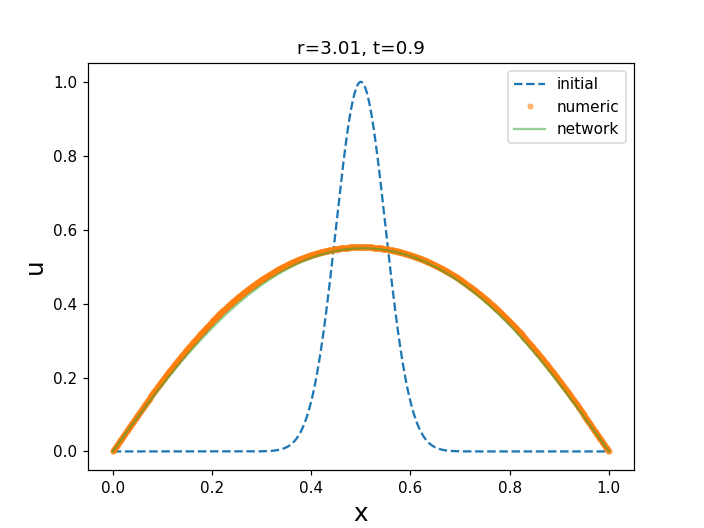

In [39]:
l = 1.
r = 3.01
dx = 1e-3
dt = 1e-3
a = .1
alpha = 10.

T = .9
x = torch.linspace(0, l, int(l/dx)+1)
u0 = initial(x).numpy()
solver = ImplicitFisherSolver(u0, a, r, l, T, dx, dt)

x = x.to(device)
t = torch.empty_like(x).fill_(T)
y = net(t, x, torch.ones_like(x)*r).detach()

y_true = np.array(solver.solve(True), 'f4')
print('max difference', max_error(torch.tensor(y_true), y.cpu()).item())
print('avg difference', avg_error(torch.tensor(y_true), y.cpu()).item())
x = x.cpu().numpy()

plt.figure() 
plt.plot(x, u0, '--', label='initial')
plt.plot(x, y_true, '.', label='numeric', alpha=.5)
plt.plot(x, y.cpu(), label='network', alpha=.5)
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f'r={r}, t={T}')
plt.legend();

### 3D difference and error plots for some $r$ value

In [26]:
l = 1.
dx = 1e-2
dt = 1e-2
a = .1
T = 1.

sizes = [int(l/dx)+1, int(T/dt)+1, 60]
xa, ta, ra = (
    torch.linspace(a, b, n, device=device)
    for (a, b), n in zip(pde.lims, sizes))

alpha = 200.
initial = lambda x: dome(x, alpha=alpha, shift=.5)
u0 = initial(xa.cpu()).numpy()

Y_true = []
for r in ra:
    solver = ImplicitFisherSolver(u0, a, r.item(), l, T, dx, dt)
    Y_true.append(solver.solve())
Y_true = np.array(Y_true, 'f4')

r, t, x = torch.meshgrid(ra, ta, xa)
Y = net(t, x, r).detach().cpu().numpy()
err = Y - Y_true

<IPython.core.display.Javascript object>


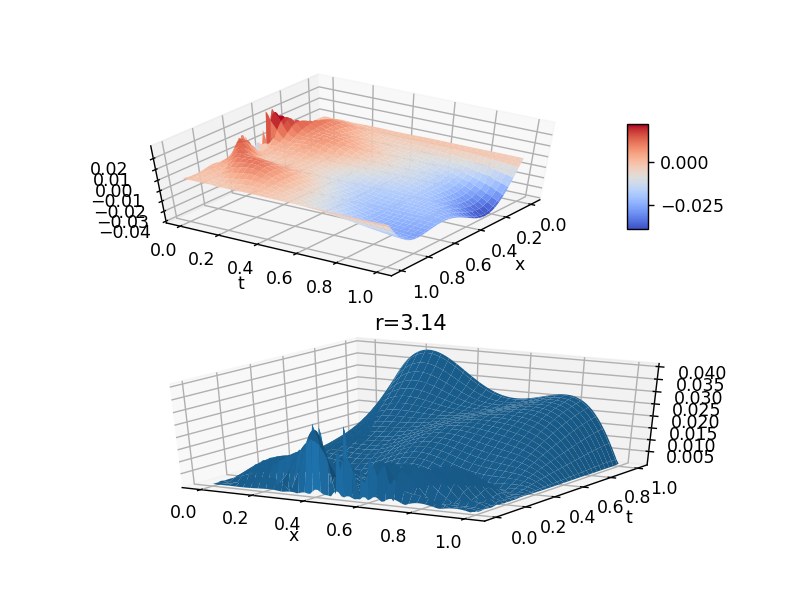

In [27]:
layer = 50
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
s1 = ax1.plot_surface(x[0].cpu(), t[0].cpu(), err[layer], cmap=cm.coolwarm)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
fig.colorbar(s1, shrink=.5, aspect=5)

ax2 = fig.add_subplot(212, projection='3d')
ax2.plot_surface(x[0].cpu(), t[0].cpu(), np.abs(err[layer]))
ax2.set_xlabel('x')
ax2.set_ylabel('t')

plt.title('r={:.2f}'.format(ra[layer]));

### About Fisher-Kolmogorov equation
! Unfinished section !

In [6]:
l = 1.
dx = 1e-2
dt = 1e-2
a = .1
T = 1.
alpha = 200.

ra = np.linspace(0., 100., 400)
xa = torch.linspace(0, l, int(l/dx)+1)
u0 = dome(xa, alpha=alpha, shift=.5).numpy()

Y_true = []
for r in ra:
    solver = ImplicitFisherSolver(u0, a, r, l, T, dx, dt)
    Y_true.append(solver.solve(True))
Y_true = np.array(Y_true, 'f4')

<IPython.core.display.Javascript object>


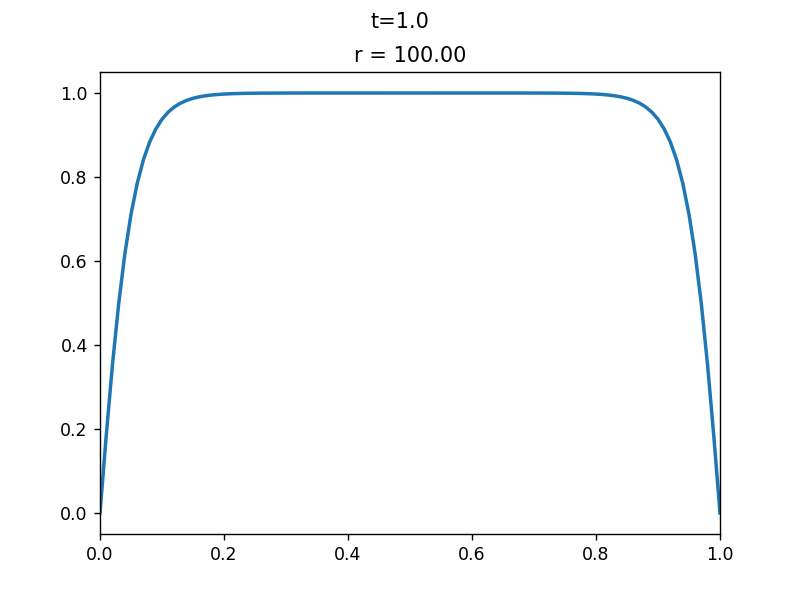

In [7]:
fig = plt.figure()
fig.suptitle(f't={T}')
ani = Anime(fig, (xa.numpy(), Y_true), string='r = {:.2f}', text=ra);